# Gaussian Process Regressor 

## Import libraries

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

# import sklearn method for preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt  

# import uncertainty toolbox to compute and plot metrics
import uncertainty_toolbox as uct

# import the gaussian process from scikit-learn 
import sklearn.gaussian_process as gp

# goat3 import methods
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

2022-08-22 16:49:44.820976: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 16:49:44.826988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 16:49:44.827000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and Preprocess data

In [2]:
data = pd.read_excel("../../../Data/dense_data.xlsx")
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)
def select_columns(df, col_type=None):
    """
    Select columns from a dataframe by type.
    """
    if col_type == "numerical":
        return df.select_dtypes(exclude=['object'])
    elif col_type == "categorical":
        return df.select_dtypes(include=['object'])
    else:
        raise ValueError("col_type should be numerical or categorical")

# Create the preprocessing pipelines for numerical data.
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean', verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = Pipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical', Pipeline(steps=[
        ('get_num_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="numerical"))),
        ('transformer', numerical_transformer)])),
    ('categorical', Pipeline(steps=[
        ('get_cat_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="categorical"))),
        ('transformer',categorical_transformer)]))
    ])) 
])

In [3]:
TEST_SIZE = 0.1 # define the test size 0.2 = 20% of the data

#Preprocess Data
X_encoded = preprocessor.fit_transform(X)

#Split Data
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.7)

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


## Model 

In [4]:
#Lets define the kernel (RBF) ie the covariance matrix 
KERNEL = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

#Define the model
model = gp.GaussianProcessRegressor(kernel = KERNEL,
                                    n_restarts_optimizer = 10,
                                    alpha = 0.1,
                                    normalize_y = True)

In [5]:
%%time
model.fit(X_train, y_train)
params = model.kernel_.get_params()

CPU times: user 16min 37s, sys: 17min 35s, total: 34min 13s
Wall time: 3min 32s


In [6]:
y_pred, std = model.predict(X_test, return_std=True)

In [7]:
y_pred_train, std_train = model.predict(X_train, return_std=True)

In [8]:
residusGP = y_test-y_pred

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogram

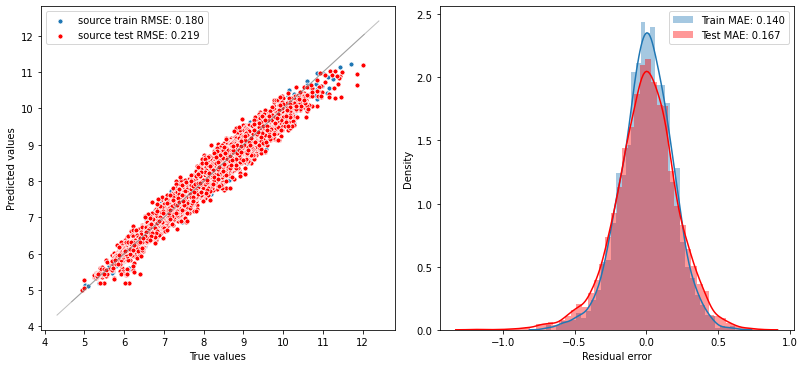

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]);ax2 = fig.add_subplot(gs[0, 1]);

plot_adequation(y_train, np.array(y_pred_train), label='source train',  ax=ax1, score='RMSE')
plot_adequation(y_test,np.array(y_pred), label='source test', ax=ax1,score='RMSE', color='red')
ax1.grid(False)
plot_residuals(y_train, np.array(y_pred_train), kind='hist', label='Train', ax=ax2, score='MAE')
plot_residuals(y_test, np.array(y_pred), kind='hist', label='Test', ax=ax2, score='MAE', color ='red')
ax2.grid(False)

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

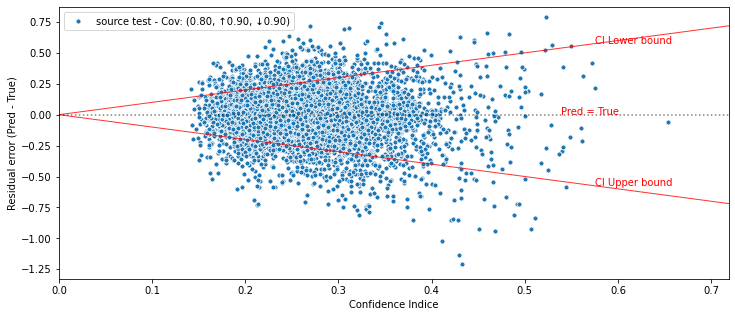

In [11]:
plot_confidence_v2(y_test,y_pred , y_pred-2*std,  y_pred+2*std, label='source test')

In [12]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(y_pred),  np.array(std), np.array(y_test), criterion='ma_cal')

In [13]:
new_stds = recalibrator(std)

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

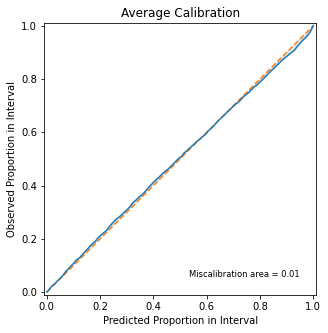

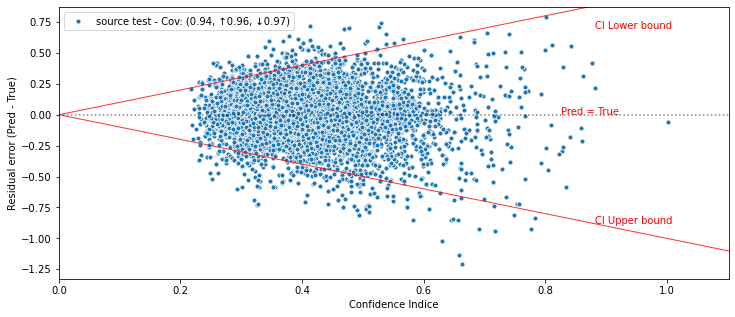

In [15]:
uct.viz.plot_calibration(np.array(y_pred),  np.array(new_stds) , np.array(y_test))
plot_confidence_v2(y_test,np.array(y_pred) , np.array(y_pred)-2*new_stds, np.array(y_pred)+2*new_stds, label='source test')

In [16]:
metrics = uct.metrics.get_all_metrics(np.array(y_pred), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.167
  RMSE          0.219
  MDAE          0.132
  MARPD         2.116
  R2            0.964
  Correlation   0.982
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.010
  Mean-absolute Calibration Error       0.008
  Miscalibration Area                   0.008
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.029
     Group Size: 0.56 -- Calibration Error: 0.013
     Group Size: 1.00 -- Calibration Error: 0.008
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.029
     Group Size: 0.56 -- Calibration Error: 0.014
     Group Size: 1.00 -- Calibration Error: 0.010
================

### Save metrics

In [17]:
import pickle

In [19]:
with open('GPR_metrics_dense.pkl', 'wb') as f:
    pickle.dump(metrics, f)